In [ ]:
from finrl.config_tickers import DOW_30_TICKER
from finrl.config import INDICATORS
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_stock_trading.env_stock_papertrading import AlpacaPaperTrading
from finrl.meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import numpy as np
import pandas as pd
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

df = pd.read_csv("btc_data.csv")

df['date'] = pd.to_datetime(df['Open_time'], unit='ms')
df['tic'] = 'BTC'
df = df.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})
df = df[['date', 'tic', 'open', 'high', 'low', 'close', 'volume']]

df = df.sort_values("date")



dp = DataProcessor(data_source='binance', time_interval='4h')  # Saatlik veri gibi düşün
processed = dp.clean_data(df)
processed = dp.add_technical_indicator(processed, INDICATORS)
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
train = processed[processed['date'] < '2024-11-01']
test = processed[processed['date'] >= '2024-11-01']

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
num_stock_shares = [0] * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct":sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,  # teknik göstergeler eklenmediyse boş bırak
    "action_space": stock_dimension,
    "reward_scaling": 1e-1,
}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)


Stock Dimension: 1, State Space: 11


In [26]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [27]:

from finrl.agents.stablebaselines3.models import DRLAgent
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_ddpg = True
if_using_ppo = True
if_using_sac = True



In [28]:
agent = DRLAgent(env = env_train)
model_ppo = agent.get_model("ppo")

trained_a2c = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device


/home/berkant/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 1139 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
| train/             |      |
|    reward          | 0.0  |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 952         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004373769 |
|    clip_fraction        | 0.042       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.000134    |
|    learning_rate        | 0.00025     |
|    loss                 | 4.53e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00355    |
|    reward               | 0.0         |
|    std        

In [29]:
df_account_value, df_actions = agent.DRL_prediction(model=trained_a2c, environment = e_train_gym)

hit end!


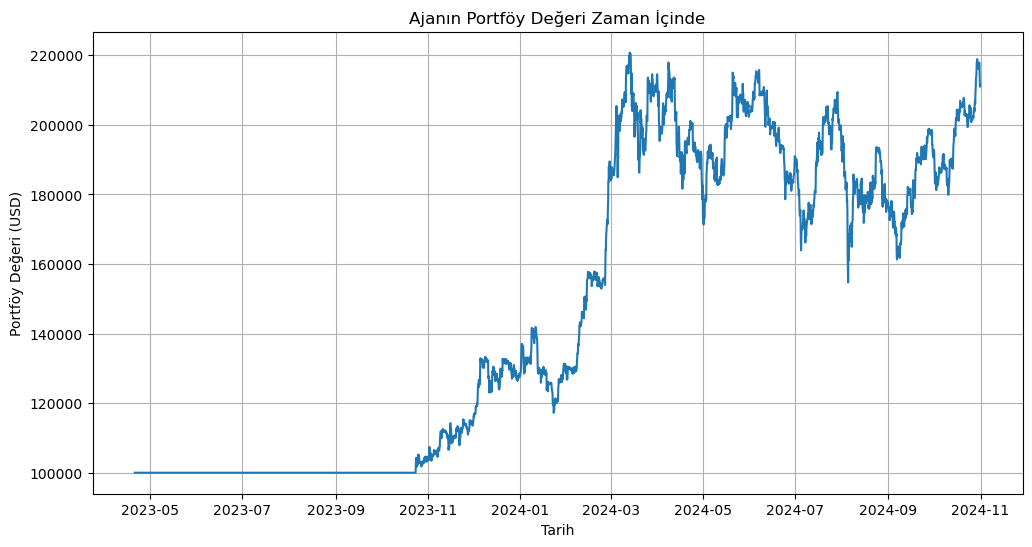

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_account_value['date'], df_account_value['account_value'])
plt.xlabel("Tarih")
plt.ylabel("Portföy Değeri (USD)")
plt.title("Ajanın Portföy Değeri Zaman İçinde")
plt.grid()
plt.show()


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (21, 8)



/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/berkant/miniconda3/lib/python3.11/site-packages/finrl/plot.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA 

Start date,2023-04-20
End date,2024-10-31
Total months,160
,Backtest
Annual return,5.779%
Cumulative returns,111.567%
Annual volatility,13.528%
Sharpe ratio,0.48
Calmar ratio,0.19
Stability,0.81
Max drawdown,-29.912%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.91,2024-03-13,2024-08-05,NaT,NaN
1,17.37,2024-01-11,2024-01-23,2024-02-09,22
2,9.98,2024-03-04,2024-03-05,2024-03-08,4
3,7.66,2023-12-09,2023-12-11,2024-01-02,16
4,6.26,2024-01-02,2024-01-03,2024-01-08,5


/home/berkant/miniconda3/lib/python3.11/site-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.03%,-8.00%,5.78%


Annual return          0.057795
Cumulative returns     1.115669
Annual volatility      0.135282
Sharpe ratio           0.483212
Calmar ratio           0.193214
Stability              0.814842
Max drawdown          -0.299122
Omega ratio            1.116708
Sortino ratio          0.694667
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.054026
Daily value at risk   -0.016785
dtype: float64


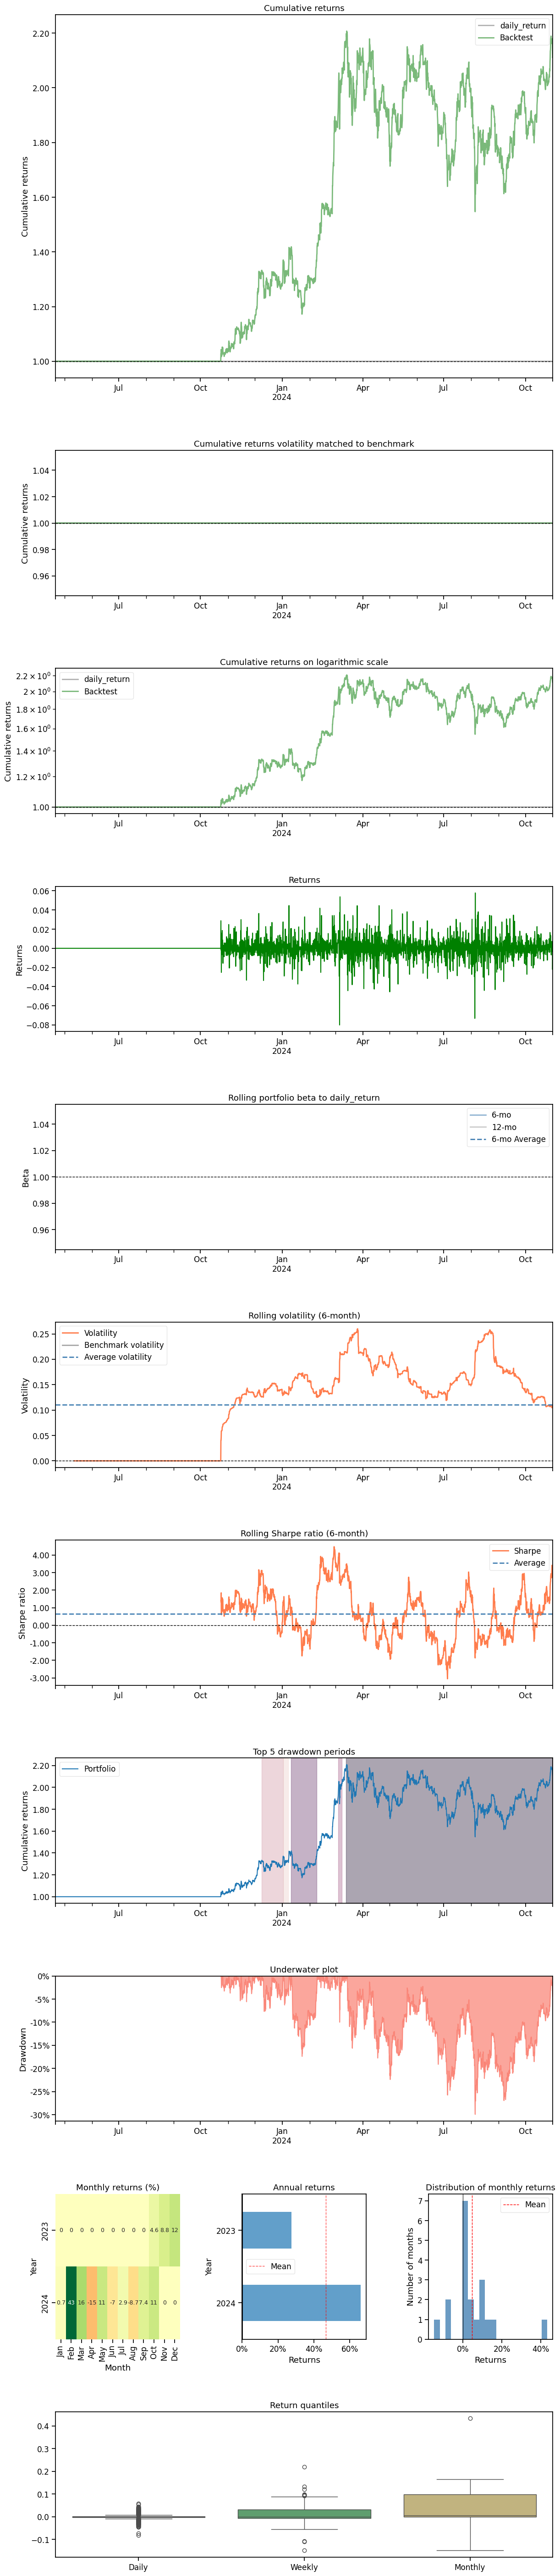

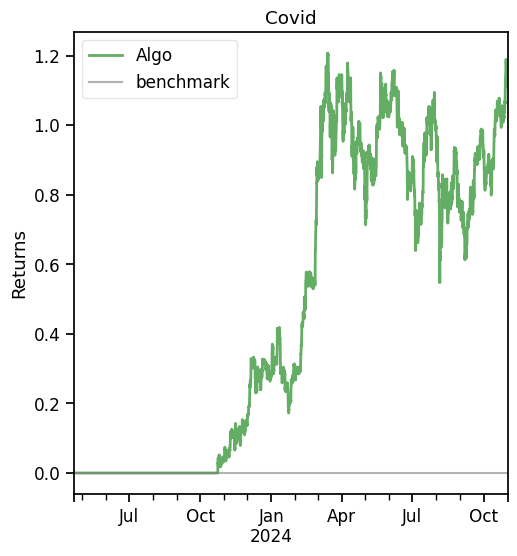

In [31]:
from finrl.plot import backtest_stats, backtest_plot, get_baseline

backtest_plot(df_account_value)
perf_stats = backtest_stats(df_account_value)